In [128]:
import torch

import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood 
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.kernels.matern_kernel import MaternKernel

from botorch.models.transforms import Normalize, Standardize
from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

import numpy as np
import tqdm

%load_ext autoreload
%autoreload 2

import helper_fns
from helper_fns.plotting_utils import plot_objectives, plot_objectives_mean_std, plot_hist_f_rho, plot_f_rho
from helper_fns.reporting_rules_postprocess import transform_x_to_tensor, report_idx_max_ymean, report_idx_max_mv, \
    report_idx_max_last_lcb_rahbo, report_idx_max_last_lcb_rahbous, report_idx_max_last_lcb_ucb

import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
# Plotting settings

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["animation.html"] = "jshtml"
from matplotlib import animation
from IPython.display import display, HTML
import seaborn as sns
sns.set_style("whitegrid")

plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams['font.size'] = 16
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [130]:
# RAHBO imports

import rahbo
from rahbo.test_functions.sine import SineBenchmark
from rahbo.optimization.bo_step import bo_step, bo_step_risk_averse, bo_step_adaptive_risk_averse
from rahbo.acquisition.acquisition import RiskAverseUpperConfidenceBound, LowerConfidenceBound

In [131]:
import pickle
with open('/home/tueilsy-st01/risk-averse-hetero-bo/hpo/pendulum/gpucb/gpucb_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [132]:
results[0]['inputs'][-3]

tensor([ 1.0000e+02,  1.0000e+03,  1.0240e+03,  2.5600e+02,  3.0000e+05,
         4.0000e+02,  3.2000e+01,  6.4000e+01,  2.0000e+00,  4.0000e+00,
         3.0000e+00,  2.0000e+00,  4.0000e+00,  9.6698e-01,  8.0444e-01,
         3.7141e-01,  6.0291e-01,  7.8727e-03, -3.1424e+00, -1.7537e+00,
        -4.2162e+00])

In [133]:
# bo_algos = ['gpucb', 'rahbo']
# bo_algos = ['gpucb']
# experiment = '/home/tueilsy-st01/safe-control-gym/examples/hpo/quadrotor_2D_attitude'
# results = {}
# for bo_algo in bo_algos:
#     # runs = os.listdir(f'{experiment}/{algo}')
#     runs = ['run1']
#     for run in runs:
#         result_path = f'{experiment}/{algo}/{run}/{bo_algo}'
#         with open(f'{result_path}/{bo_algo}_results.pkl', 'rb') as f:
#             results[bo_algo] = pickle.load(f)
# objectives = {'gpucb': results['gpucb'][0]['scores'][results['gpucb'][0]['reporting_idx']] - results['gpucb'][0]['scores_var'][results['gpucb'][0]['reporting_idx']],
#               'rahbo': results['rahbo'][0]['scores'][results['rahbo'][0]['reporting_idx']] - results['rahbo'][0]['scores_var'][results['rahbo'][0]['reporting_idx']],
#               'erahbo': results['erahbo'][0]['scores'][results['erahbo'][0]['reporting_idx']] - results['erahbo'][0]['scores_var'][results['erahbo'][0]['reporting_idx']]}
# plot_objectives(objectives, objective_name='MV($\\hat{x}_T$)', x_label='Evaluations')

In [134]:
algo = 'ppo'
bo_algos = ['gpucb', 'rahbo', 'erahbo']
gamma = 1 # risk adjust parameter
experiment = '/home/tueilsy-st01/risk-averse-hetero-bo/hpo/pendulum'

In [135]:

results = {}
gammas = {}
for bo_algo in bo_algos:
    with open(f'{experiment}/{bo_algo}/{bo_algo}_results.pkl', 'rb') as f:
        results[bo_algo] = pickle.load(f)
    with open(f'{experiment}/{bo_algo}/config.yaml', 'r') as f:
        gammas[bo_algo] = yaml.safe_load(f)['gamma']

In [136]:
results['gpucb'][0]['inputs'][results['gpucb'][0]['reporting_idx']][-1]

tensor([ 1.0000e+03,  1.0000e+03,  1.0240e+03,  2.5600e+02,  3.0000e+05,
         2.0000e+02,  6.4000e+01,  6.4000e+01,  2.0000e+00,  4.0000e+00,
         3.0000e+00,  2.0000e+00,  4.0000e+00,  9.6715e-01,  8.0463e-01,
         3.7063e-01,  6.0386e-01,  7.9110e-03, -3.1425e+00, -1.7674e+00,
        -4.2339e+00])

In [137]:
results['gpucb'][0]['inputs'][32].shape

torch.Size([21])

In [138]:
results['erahbo'][0]['scores'][9]

tensor([-7.8198], dtype=torch.float64)

In [139]:
torch.cat([results['gpucb'][i]['scores'][results['gpucb'][i]['reporting_idx']] for i in range(len(results['gpucb']))], dim=1).shape

torch.Size([500, 3])

In [140]:

objectives = {}
for bo_algo in bo_algos:
    gamma = gammas[bo_algo]
    if bo_algo == 'erahbo':
        min_shape = min([results[bo_algo][i]['scores'][results[bo_algo][i]['reporting_idx']].shape[0] for i in range(len(results[bo_algo]))])
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['scores'][results[bo_algo][i]['reporting_idx']][:min_shape] - gamma * results[bo_algo][i]['scores_var'][results[bo_algo][i]['reporting_idx']][:min_shape] for i in range(len(results[bo_algo]))], dim=1)
    else:
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['scores'][results[bo_algo][i]['reporting_idx']] - gamma * results[bo_algo][i]['scores_var'][results[bo_algo][i]['reporting_idx']] for i in range(len(results[bo_algo]))], dim=1)

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='Evaluations', ylabel='MV($\\hat{x}_T$)'>)

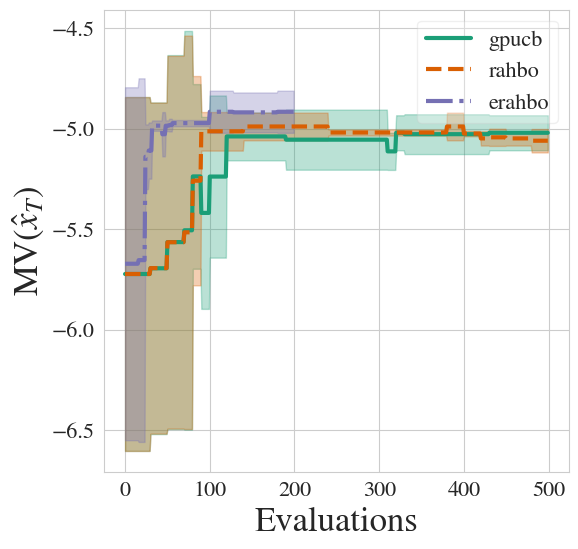

In [141]:
plot_objectives_mean_std(objectives, objective_name='MV($\\hat{x}_T$)', x_label='Evaluations')

In [142]:

objectives = {}
for bo_algo in bo_algos:
    gamma = gammas[bo_algo]
    if bo_algo == 'erahbo':
        min_shape = min([results[bo_algo][i]['scores'][results[bo_algo][i]['reporting_idx']].shape[0] for i in range(len(results[bo_algo]))])
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['scores'][results[bo_algo][i]['reporting_idx']][:min_shape] for i in range(len(results[bo_algo]))], dim=1)
    else:
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['scores'][results[bo_algo][i]['reporting_idx']] for i in range(len(results[bo_algo]))], dim=1)

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='Evaluations', ylabel='f($\\hat{x}_T$)'>)

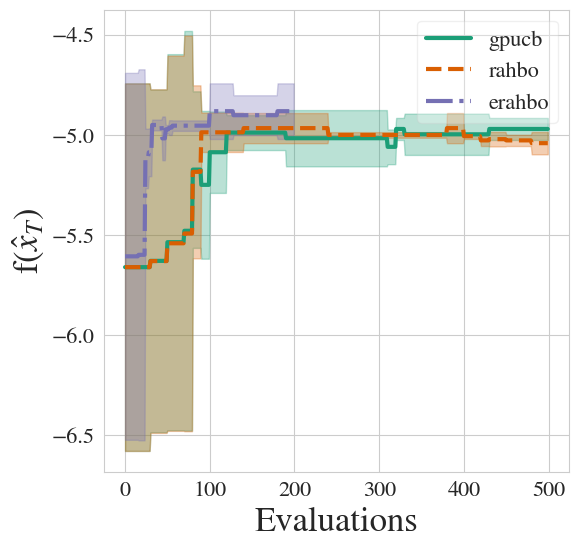

In [143]:
plot_objectives_mean_std(objectives, objective_name='f($\\hat{x}_T$)', x_label='Evaluations')

In [144]:

objectives = {}
for bo_algo in bo_algos:
    gamma = gammas[bo_algo]
    if bo_algo == 'erahbo':
        min_shape = min([results[bo_algo][i]['eval_scores'].shape[0] for i in range(len(results[bo_algo]))])
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['eval_scores'][:min_shape] - gamma * results[bo_algo][i]['eval_scores_var'][:min_shape] for i in range(len(results[bo_algo]))], dim=1)
    else:
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['eval_scores'] - gamma * results[bo_algo][i]['eval_scores_var'] for i in range(len(results[bo_algo]))], dim=1)

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='BO Iterations', ylabel='MV($\\hat{x}_T$)'>)

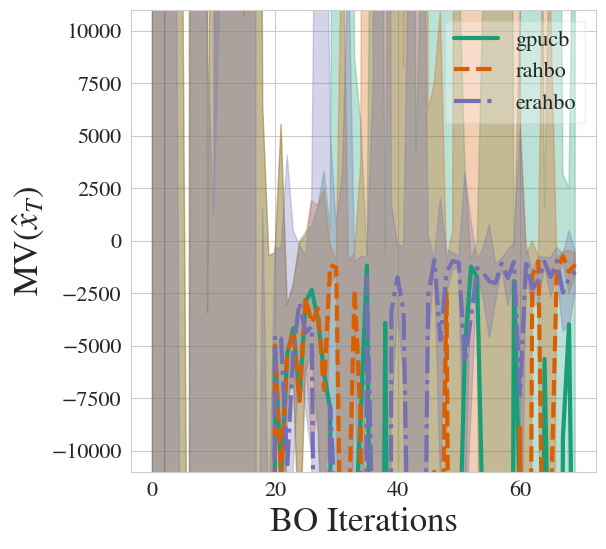

In [145]:
plot_objectives_mean_std(objectives, objective_name='MV($\\hat{x}_T$)', x_label='BO Iterations', ylim=(-11000, 11000))

In [146]:

objectives = {}
for bo_algo in bo_algos:
    gamma = gammas[bo_algo]
    if bo_algo == 'erahbo':
        min_shape = min([results[bo_algo][i]['eval_scores'].shape[0] for i in range(len(results[bo_algo]))])
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['eval_scores'][:min_shape] for i in range(len(results[bo_algo]))], dim=1)
    else:
        objectives[bo_algo] = torch.cat([results[bo_algo][i]['eval_scores'] for i in range(len(results[bo_algo]))], dim=1)

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:xlabel='BO Iterations', ylabel='f($\\hat{x}_T$)'>)

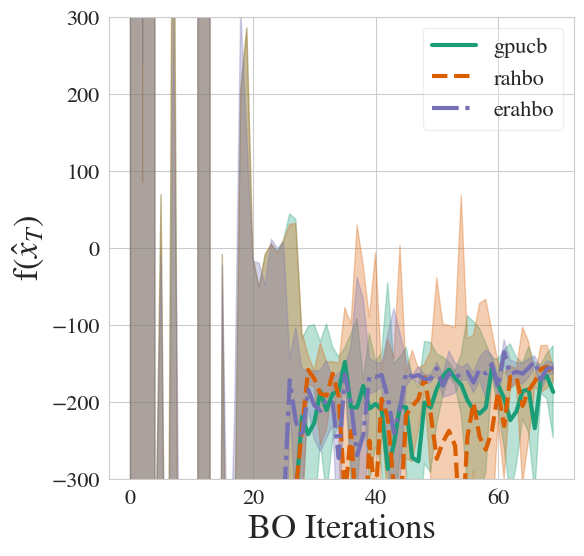

In [147]:
plot_objectives_mean_std(objectives, objective_name='f($\\hat{x}_T$)', x_label='BO Iterations', ylim=(-300, 300))